In [145]:
import whisper
import os
import pandas as pd
import torch
from xml.etree import ElementTree as ET
import nltk
import warnings
import numpy as np
import re
import pytz
from datetime import datetime,timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import yfinance as yf
import json
nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coooo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [146]:
from configparser import ConfigParser
from pathlib import Path
BASE_DIR =Path.cwd().parent
print(BASE_DIR)
CONFIG = ConfigParser()
CONFIG.read(BASE_DIR / "config.ini")
POLYGON_KEY = CONFIG.get("UPSTREAM", "polygon_api_key")


e:\BNY Mellon capstone project\BKG


In [171]:
audio_path = "recording"
audio_file = "The Bank of New York Mellon Corporation (NYSE_BK) Apr-16-2024 - Audio.mp3"
store_path = "S2T"
store_S2T = "S2T/BK-Q1-2024-S2T.json"
xml_path = "xml"
# xml_file = "BK-Q1-2024.xml"
xml_file = "BK-Q1-2024.xml"
output_file = "BK-Q1-2024_timestamp.xml"
stock_folder = "stock"


In [45]:


# 加载模型
model = whisper.load_model("base")

# 进行语音识别
result = model.transcribe(os.path.join(audio_path, audio_file))

# # 打印结果
for segment in result["segments"]:
    print(f"Start: {segment['start']}s, End: {segment['end']}s, Text: {segment['text']}")


KeyboardInterrupt: 

In [8]:

with open(os.path.join(store_path,store_S2T), 'w') as f:
    json.dump(result, f)

In [9]:
with open('data.txt', 'w') as file:
    json.dump(result["text"], file)

In [172]:
with open(store_S2T, 'r') as file:
    result = json.load(file)


In [173]:
print(result["text"][-100:])

e on the BNY Mallon investor relations website at two Eastern standard time today. Have a great day.


In [174]:
for segment in result["segments"]:
    print(f"Start: {segment['start']}s, End: {segment['end']}s, Text: {segment['text']}")

Start: 0.0s, End: 5.6000000000000005s, Text:  Good morning and welcome to the 2024 First Quarter Earnings Conference call hosted by
Start: 5.6000000000000005s, End: 6.6000000000000005s, Text:  BMI Mellon.
Start: 6.6000000000000005s, End: 10.52s, Text:  At this time, all participants are in a list and only mode.
Start: 10.52s, End: 13.88s, Text:  Later we will conduct a question and answer session.
Start: 13.88s, End: 18.52s, Text:  Please note that this conference call and webcast will be recorded and will consist of
Start: 18.52s, End: 20.56s, Text:  copyrighted material.
Start: 20.56s, End: 26.36s, Text:  You may not record or rebroadcast these materials without BMI Mellon's consent.
Start: 26.36s, End: 32.0s, Text:  I will now turn the call over to Marius Murz, BMI Mellon, head of investor relations.
Start: 32.0s, End: 33.36s, Text:  Please go ahead.
Start: 33.36s, End: 36.36s, Text:  Thank you operator.
Start: 36.36s, End: 39.28s, Text:  Good morning everyone and thanks for joining

In [175]:
import difflib

def find_best_match(original_text, transcribed_segments):
    matcher = difflib.SequenceMatcher(None, original_text, transcribed_segments)
    match = matcher.find_longest_match(0, len(original_text), 0, len(transcribed_segments))
    return original_text[match.a: match.a + match.size]


original_text = "Good morning, and welcome to State Street Corporation's First Quarter 2024 Earnings Conference Call and Webcast. Today's discussion is being broadcasted live on State Street's website at investors.statestreet.com. This conference call is also being recorded for replay. State Street's conference call is copyrighted, and all rights are reserved. This call may not be recorded or rebroadcast or distribution in whole or in part without the expressed written authorization from State Street Corporation. The only authorized broadcast of this call will be housed on the State Street website. Now I would like to introduce Ilene Fiszel Bieler, Global Head of Investor Relations at State Street. Please go ahead."
transcribed_segments = " Good morning and welcome to State Street Corporations, first quarter 2024 earnings conference"

best_match = find_best_match(original_text, transcribed_segments)
print("Best match found:", best_match)

Best match found:  and welcome to State Street Corporation


In [176]:
def parse_time(time_str):
    
    return datetime.strptime(time_str, '%A, %B %d, %Y %I:%M %p %Z')

def timeAndTicker(root):
    time_element = root.find(".//header/time")
    if time_element is not None:
        time_element = parse_time(time_element.text)
    ticker =  root.find(".//header/ticker").text
    return time_element, ticker




In [177]:
def preprocess_text(text):
    
    import re
    return re.sub(r'\W+', ' ', text.lower()).strip()

def calculate_similarity(text1, text2):
    
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
def split_text_into_sentences(text):

    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    return tokenizer.tokenize(text)
def find_most_similar_sentence(sentence, segments):
    vectorizer = TfidfVectorizer()

    max_similarity = 0
    best_segment = None
    best_index = -1
    target_length = len(preprocess_text(sentence))

    
    for start_index in range(len(segments)):
        combined_text = ""
        for end_index in range(start_index, len(segments)):
            combined_text += " " + segments[end_index]['text']
            combined_length = len(preprocess_text(combined_text))


            if combined_length < target_length * 1.5 or (target_length< 10 and combined_length < target_length * 56):  # 允许一定的长度超出
                processed_combined_text = preprocess_text(combined_text)
                all_texts = [preprocess_text(sentence), processed_combined_text]
                tfidf_matrix = vectorizer.fit_transform(all_texts)
                similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
                # print(similarity)
               
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_segment = segments[end_index]
                    best_index = end_index
            else:
                break  
    
    return best_segment, max_similarity, best_index
def get_last_two_sentences(text):

    sentences = split_text_into_sentences(text)
    # Combine the last two sentences, handle texts with less than two sentences.
    last_two_sentences = " ".join(sentences[-2:]) if len(sentences) >= 2 else " ".join(sentences)
    return last_two_sentences

In [178]:
def convert_gmt_to_et(gmt_time):
    
    print(f"gmt_time: {gmt_time}") 
    if gmt_time.tzinfo is None or gmt_time.tzinfo.utcoffset(gmt_time) is None:
        gmt_timezone = pytz.timezone('GMT')
        gmt_time = gmt_timezone.localize(gmt_time)  # 给 naive datetime 设置 GMT 时区

    et_timezone = pytz.timezone('America/New_York')
    et_time = gmt_time.astimezone(et_timezone)  # 转换到 ET 时区
    print(f"et_time: {et_time}")  
    return et_time

def load_daily_stock_data(ticker, date):

    start_date = date
    end_date = pd.to_datetime(date).date() + pd.Timedelta(days=1)
    data = yf.download(ticker, start=start_date, end=end_date, interval='1m')
    return data
def get_specific_data(specific_time, stock_data):
    specific_time = pd.to_datetime(specific_time)  # 确保这是 datetime 对象
    print(specific_time)
    specific_data = None
    if specific_time in stock_data.index:
        specific_data = stock_data.loc[specific_time]
        print(specific_data)
    else:
        print("No data available for the specified time.")
    return specific_data

def round_time_to_nearest_minute(dt):

    # 四舍五入的逻辑：如果秒数大于等于30，增加一分钟
    new_minute = dt + timedelta(minutes=1) if dt.second >= 30 else dt
    return new_minute.replace(second=0, microsecond=0)

In [179]:
global_time = []
global_price = []

In [180]:
def add_presentation_stockprice_to_xml(root, time, stock_data, SP500_data, KBW_data, result):
    """
    Add summaries to the XML file based on the section presentation.
    
    Args:
        root: ElementTree of the transcript
    """
    
    print("processing presentation section")
    # Assume result is accessible and contains the whisper_segments
    whisper_segments = result["segments"]
    prev_time = None
    for statement_element in root.findall(".//statement"):
        speaker_element = statement_element.find("speaker")
        text_element = speaker_element.find("text")
        text = text_element.text.strip()

        last_sentence = get_last_two_sentences(text)

        best_segment, best_similarity, best_index = find_most_similar_sentence(last_sentence, whisper_segments)

        # Print the best matching segment's text, similarity score, and times
        # print("Target sentence: ", last_sentence)
        # print("Best Matching Segment:", best_segment['text'])
        # print("Similarity Score:", best_similarity)
        # print(f"Start Time: {best_segment['start']}s, End Time: {best_segment['end']}s")
        
        
        end_time_gmt = time + timedelta(seconds=best_segment['end'])
        rounded_end_time_gmt = round_time_to_nearest_minute(end_time_gmt)
        end_time_et = convert_gmt_to_et(rounded_end_time_gmt)
        stock_time_str = end_time_et.strftime('%Y-%m-%d %H:%M:%S')
        stock_price = get_specific_data(stock_time_str, stock_data)
        SP500 = get_specific_data(stock_time_str, SP500_data)
        KBW = get_specific_data(stock_time_str, KBW_data)
        # print(f"Global time: {end_time_gmt}")
        # print(f"stock_data: ", stock_data)
        # print(stock_data)
        # print("----------------------------------------------------")
        timestamp_element = ET.SubElement(text_element, "timeStamp")

        timestamp_element.text = end_time_gmt.strftime('%H:%M:%S')
        stock_element = ET.SubElement(text_element, "stock_price")
        stock_element.text = f"{stock_price['Close']:.6f}"
        S_P500_element = ET.SubElement(text_element, "S_P500")
        
        S_P500_element.text = f"{SP500['Close']:.6f}" 
        KBW_element = ET.SubElement(text_element, "KBW")
        KBW_element.text = f"{KBW['Close']:.6f}"
        global_time.append(end_time_et)
        global_price.append(stock_price)

        # if "[" in text:
        #     print("\nTrigger\n")
        #     ending_text = text.split(']')[-1]
        #     sentence = split_text_into_sentences(ending_text)[0]
        #     # print(f"ending text: {sentence}")
        #     best_segment, best_similarity,max_index = find_most_similar_sentence(sentence, whisper_segments[i:])
        #     # print("Best Matching Segment:", best_segment['text'])
        #     # print("Similarity Score:", best_similarity)
        #     # print(whisper_segments[max_index]["text"], whisper_segments[i+max_index]["text"])
        #     i = i+max_index
        #     start_index = i
        #     processed_paragraph = preprocess_text(ending_text)

        # while i < len(whisper_segments):
        #     current_text += " " + whisper_segments[i]['text']
        #     new_processed_text = preprocess_text(current_text)
        #     similarity = calculate_similarity(processed_paragraph, new_processed_text)
        #     print(similarity)
        #     if similarity > max_similarity:
        #         max_similarity = similarity
        #         best_match_text = current_text
        #         i += 1
                
        #     elif similarity > 0.7 and similarity < max_similarity and abs(len(current_text) - len(processed_paragraph))< 30:
        #         start_index = i
        #         break
        #     else:
        #         i +=1
        # print(f"origin Text: {processed_paragraph}")
        # print(f"Matched Text: {best_match_text}")
        # print(f"Start Time: {whisper_segments[start_index]['start']}s, End Time: {whisper_segments[i]['end']}s")    
        # print("----------------------------------------------------")

        # # Use summarizer to get the summary for the text
        # summary = self.summarizer.summarize(text, "statement")
        # # Create and append the summary tag
        # summary_element = ET.SubElement(text_element, "summary")
        # summary_element.text = summary
    return root


In [181]:
def add_QA_stockprice_to_xml(root, time, stock_data, SP500_data, KBW_data,result):
        """
        Add summaries to the XML file based on the section Question and Answer.
        
        Args:
            root: ElementTree of the transcript
        """
        print("processing QA section")
        whisper_segments = result["segments"]
        # Find the <section name="Question and Answer"> section
        qa_section = root.find("./body/section[@name='Question and Answer']")

        # Iterate over the elements within the section 
        text_type = ""
        prev_time = None
        for element in qa_section.iter():
            
            # 
            if element.tag == "transition" or element.tag=="ending":
                text_type = "transition"
                
            elif "question" in element.tag.lower():
                text_type = "question"
                
            elif "answer" in element.tag.lower():
                text_type = "answer"
                
                

            if element.tag == 'text':

                if text_type == "question":

                    text = ""
                    if element.text is None:
                        print("There is None text in Q&A")
                        print("_________________________________________")
                    else:
                        text = element.text.strip()
                    

                    last_sentence = get_last_two_sentences(text)

                    best_segment, best_similarity, best_index = find_most_similar_sentence(last_sentence, whisper_segments)

                    # Print the best matching segment's text, similarity score, and times
                    print("Target sentence: ", last_sentence)
                    # print("Best Matching Segment:", best_segment['text'])
                    # print("Similarity Score:", best_similarity)
                    # print(f"Start Time: {best_segment['start']}s, End Time: {best_segment['end']}s")
                    if best_segment == None:
                        timestamp_element = ET.SubElement(element, "timeStamp")
                        timestamp_element.text = "None"
                        stock_element = ET.SubElement(element, "stock_price")
                        stock_element.text = "None"
                        continue
                     
                    end_time_gmt = time + timedelta(seconds=best_segment['end'])
                    rounded_end_time_gmt = round_time_to_nearest_minute(end_time_gmt)
                    end_time_et = convert_gmt_to_et(rounded_end_time_gmt)
                    stock_time_str = end_time_et.strftime('%Y-%m-%d %H:%M:%S')
                    stock_price = get_specific_data(stock_time_str, stock_data)
                    SP500 = get_specific_data(stock_time_str, SP500_data)
                    KBW = get_specific_data(stock_time_str, KBW_data)
                    
                    timestamp_element = ET.SubElement(element, "timeStamp")
                    timestamp_element.text = end_time_gmt.strftime('%H:%M:%S')
                    stock_element = ET.SubElement(element, "stock_price")
                    stock_element.text = f"{stock_price['Close']:.6f}"
                    S_P500_element = ET.SubElement(element, "S_P500")
                    S_P500_element.text = f"{SP500['Close']:.6f}" 
                    KBW_element = ET.SubElement(element, "KBW")
                    KBW_element.text = f"{KBW['Close']:.6f}"
                    global_time.append(end_time_et)
                    global_price.append(stock_price)

        return root

In [182]:
tree = ET.parse(os.path.join(xml_path,xml_file))
root = tree.getroot()
time, ticker = timeAndTicker(root)


In [183]:
print(convert_gmt_to_et(time))
stock_data = load_daily_stock_data(ticker,convert_gmt_to_et(time))

[*********************100%%**********************]  1 of 1 completed

gmt_time: 2024-04-16 15:00:00
et_time: 2024-04-16 11:00:00-04:00
2024-04-16 11:00:00-04:00
gmt_time: 2024-04-16 15:00:00
et_time: 2024-04-16 11:00:00-04:00


In [184]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-04-16 11:00:00-04:00,54.130001,54.180000,54.099998,54.180000,54.180000,0
2024-04-16 11:01:00-04:00,54.205002,54.215000,54.150002,54.180000,54.180000,6521
2024-04-16 11:02:00-04:00,54.185001,54.270000,54.185001,54.270000,54.270000,12312
2024-04-16 11:03:00-04:00,54.264999,54.355000,54.259998,54.340000,54.340000,10955
2024-04-16 11:04:00-04:00,54.349998,54.400002,54.345200,54.369999,54.369999,12112
...,...,...,...,...,...,...
2024-04-16 15:55:00-04:00,53.959999,54.009998,53.919998,53.950001,53.950001,77564
2024-04-16 15:56:00-04:00,53.939999,53.965000,53.910000,53.924999,53.924999,68750
2024-04-16 15:57:00-04:00,53.924999,54.000000,53.924999,53.970001,53.970001,100396


In [185]:
SP500_data = load_daily_stock_data("^GSPC",convert_gmt_to_et(time))
BKX_data = load_daily_stock_data("^BKX",convert_gmt_to_et(time))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

gmt_time: 2024-04-16 15:00:00
et_time: 2024-04-16 11:00:00-04:00
gmt_time: 2024-04-16 15:00:00
et_time: 2024-04-16 11:00:00-04:00


In [186]:
tree = ET.parse(os.path.join(xml_path,xml_file))
root = tree.getroot()
time, ticker = timeAndTicker(root)
print(time, ticker)
root = add_presentation_stockprice_to_xml(root,time,stock_data, SP500_data, BKX_data, result)
root = add_QA_stockprice_to_xml(root, time, stock_data, SP500_data, BKX_data,result)
tree.write(output_file, encoding='utf-8', xml_declaration=True)
print(f"Processed {output_file}")

2024-04-16 15:00:00 BK
processing presentation section
gmt_time: 2024-04-16 15:01:00
et_time: 2024-04-16 11:01:00-04:00
2024-04-16 11:01:00
Open           54.205002
High           54.215000
Low            54.150002
Close          54.180000
Adj Close      54.180000
Volume       6521.000000
Name: 2024-04-16 11:01:00-04:00, dtype: float64
2024-04-16 11:01:00
Open         5.046600e+03
High         5.046900e+03
Low          5.045170e+03
Close        5.046240e+03
Adj Close    5.046240e+03
Volume       3.656645e+06
Name: 2024-04-16 11:01:00-04:00, dtype: float64
2024-04-16 11:01:00
Open         96.814796
High         96.846703
Low          96.791298
Close        96.791298
Adj Close    96.791298
Volume        0.000000
Name: 2024-04-16 11:01:00-04:00, dtype: float64
gmt_time: 2024-04-16 15:02:00
et_time: 2024-04-16 11:02:00-04:00
2024-04-16 11:02:00
Open            54.185001
High            54.270000
Low             54.185001
Close           54.270000
Adj Close       54.270000
Volume       1231

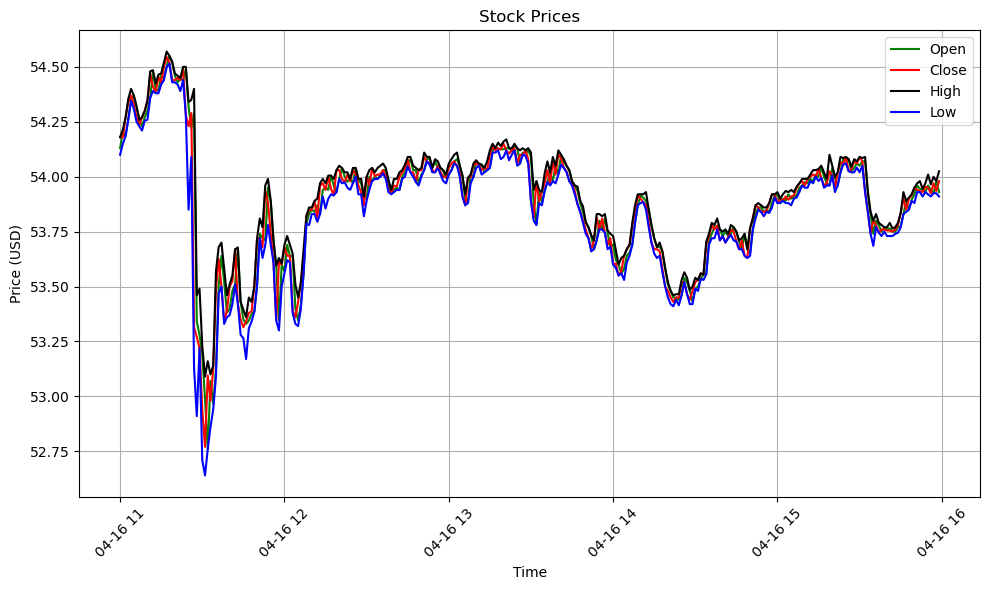

In [187]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stock_data(stock_data):
    """
    Plots the stock data for open, close, high, and low prices.

    Args:
        stock_data (DataFrame): DataFrame containing the stock data with datetime index.
    """
    # Check if data is empty
    if stock_data.empty:
        print("No data available to plot.")
        return

    # Ensure the index is a datetime index
    stock_data.index = pd.to_datetime(stock_data.index)

    plt.figure(figsize=(10, 6))
    plt.plot(stock_data.index, stock_data['Open'], label='Open', color='green')
    plt.plot(stock_data.index, stock_data['Close'], label='Close', color='red')
    plt.plot(stock_data.index, stock_data['High'], label='High', color='black')
    plt.plot(stock_data.index, stock_data['Low'], label='Low', color='blue')

    plt.title('Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate dates for better visibility
    plt.tight_layout()  # Adjust subplots to give some padding

    plt.show()

# Example usage
# Assuming 'stock_data' is your DataFrame loaded with stock prices
plot_stock_data(stock_data)

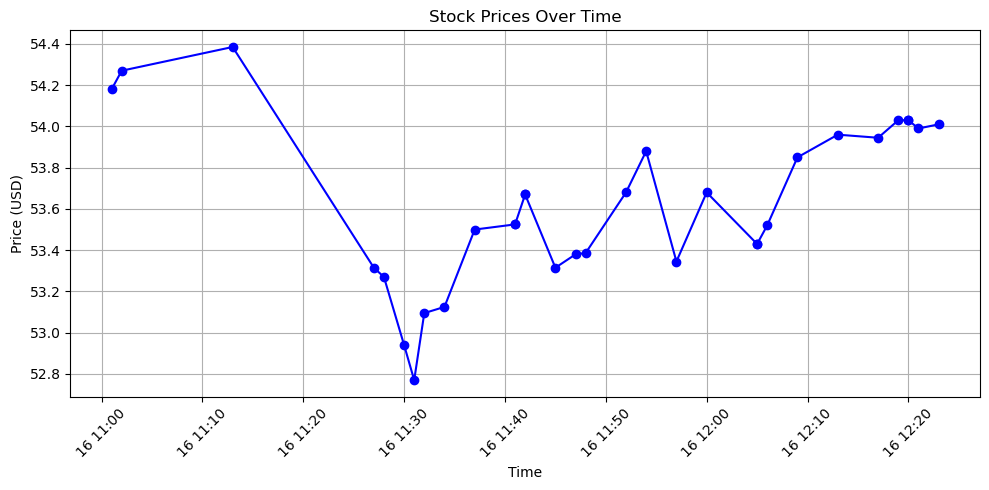

In [188]:

def create_and_sort_dataframe(global_times, global_prices):
    df = pd.DataFrame({
        'Time': global_times,
        'Price': [price['Close'] for price in global_prices]  
    })
    df['Time'] = pd.to_datetime(df['Time']) 
    df.sort_values('Time', inplace=True)  
    return df


def plot_stock_prices(df):
    plt.figure(figsize=(10, 5))
    plt.plot(df['Time'], df['Price'], marker='o', linestyle='-', color='b')
    plt.title('Stock Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

df = create_and_sort_dataframe(global_time, global_price)
plot_stock_prices(df)

In [170]:
stock_data.to_csv(os.path.join(stock_folder, xml_file.replace("xml","csv")))

In [169]:
SP500_data.to_csv(os.path.join(stock_folder, xml_file.replace(".xml","-SP500.csv")))
BKX_data.to_csv(os.path.join(stock_folder, xml_file.replace(".xml","-KBW.csv")))